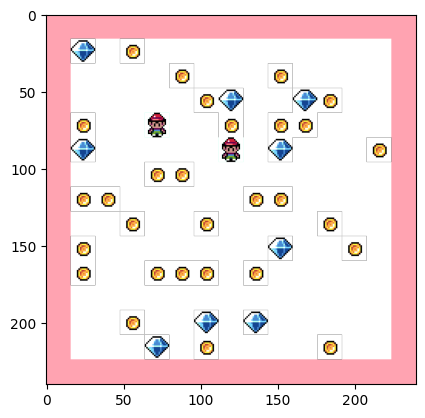

0.0
[0, 0]
Please try again. Possible actions are below.
[0 1 2 3 4 5]


UnboundLocalError: cannot access local variable 'action' where it is not associated with a value

In [1]:
%load_ext autoreload

# --------------- #
# region: Imports #
import os
import sys
module_path = os.path.abspath('../../..')
if module_path not in sys.path:
    sys.path.insert(0, module_path)
# endregion       #
# --------------- #

from examples.state_punishment.utils import (
    init_log, parse_args, load_config,
    create_models,
    create_agents,
    create_entities
)
config_path = '../configs/config.yaml'
from examples.state_punishment import agents, entities
from examples.state_punishment.env import state_punishment
from agentarium.logging_utils import GameLogger
from agentarium.models import human_player
from agentarium.utils import visual_field_sprite, image_from_array
from examples.state_punishment.state_sys import state_sys
from IPython.display import clear_output
from matplotlib import pyplot as plt
import random
import argparse

cfg = load_config(argparse.Namespace(config=config_path))

models = create_models(cfg)
agents = create_agents(cfg, models)
entities = create_entities(cfg)
env = state_punishment(cfg, agents, entities)

for ixs, agent in enumerate(agents):
    agent.model = human_player.ModelHumanPlayer(
         action_space=6, 
         state_size = cfg.model.iqn.parameters.state_size, 
         memory_size=1, 
         name=f'human {ixs}')

for epoch in range(cfg.experiment.epochs):
    # Reset the environment at the start of each epoch
        env.reset()
        # for agent in env.agents:
        #     agent.reset(env)
        random.shuffle(agents)

        scores = GameLogger(max_epochs=1)

        # initialize state system
        state_entity = state_sys(
            cfg.state_sys.init_prob, 
            cfg.state_sys.magnitude, 
            cfg.state_sys.taboo,
            cfg.state_sys.change_per_vote
            )
        
        env.cache['delayed_r'] = [0 for _ in range(len(agents))]

        done = 0 
        turn = 0
        losses = 0
        game_points = [0 for _ in range(len(agents))]

        while not done:

            turn = turn + 1

            entities = env.get_entities_for_transition()
            # Entity transition
            for entity in entities:
                entity.transition(env)

            img = visual_field_sprite(env.world, tile_size = env.tile_size)
            clear_output(wait = True)
            # scores.pretty_print(
            #      'jupyter-mode',
            #      epoch = epoch,
            #      turn = turn,
            #      reward = game_points,
            # )
            
            img = image_from_array(img)
            plt.imshow(img)
            plt.show()
            print(state_entity.prob)
            print(game_points)


            # Agent transition
            for agent in agents:

                (state,
                action,
                reward,
                next_state,
                done_
                ) = agent.transition(env, state_entity)

                img = visual_field_sprite(env.world, tile_size = env.tile_size)
                img = image_from_array(img)
                print(agent.model.name)
                plt.imshow(img)
                plt.show()

                if turn >= cfg.experiment.max_turns or done_:
                    done = 1

                exp = (1, (state, action, reward, next_state, done))
                # agent.episode_memory.append(exp)

                game_points[agent.ixs] += reward

what else do we need?

1. entities: a bad resource that harm others 
    1.1 so you need to code the mechanism that when taking the bad resource, others get a loss of reward
2. a state punishment class: simply a probability item
    2.1 change when agents vote
3. additional actions for vote for and vote agains a punishment towards transgressors
4. mark for transgressor? or start from simple, suppose we have a god who knows everything, and everytime an agent make a transgression, it will be punished

1. remove all other entities except gem and coins. Gem is good. Coins is even more valuable, but harm others. When an agent takes a coin, the system records it, and then in next timestep all other agents lose 5 points. (env.info? like env.info.harm and agent.last_action) (env.info.external_r = {a_x1: -5,  a_x2:-5, ....}, everytime an agent performs an act, add the r in the dict and reset the number, and also based on its action update the dict)
2. transition: r += state_punishment_prob * punishment_intensity * is_violation; include state_punishment as a parameter in transition()
3. agent actions: if action == 4, then state_punishment.prob -= magnitude_of_change; elif action == 5, state_punishment.prob += magnitude_of_change
4. state punishment entity: class state_punishment, init()--self.prob == 0, self.intensity = intensity